# Lesson 4

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open("makemore/names.txt", 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):

    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # Roling window -> crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])             # 80%
Xval, Yval = build_dataset(words[n1:n2])         # 10%
Xte, Yte = build_dataset(words[n2:])             # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### "Problemi" di inizializzazione:<br>
Il valore della loss alla prima iterazione è 27. che è molto alto<br>
All'inizio ci aspettiamo che tutti i caratteri abbiano una distribuzione di probabilità uniforme<br>
E questo si può calcolare matematicamente, genererebbe una loss di circa 3.8<br>
Per cui risolviamo avvicinando a 0 l'inizializzazione:<br><br>
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1<br>
b2 = torch.randn(vocab_size,                        generator=g) * 0


In [60]:
# MLP revised
n_embd = 10    # The dimensionality of the character embedding vectors
n_hidden = 200 # The number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),               generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size)**0.5  #* 0.2
#b1 = torch.randn(n_hidden,                          generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

# Batch normalization gain
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


Concetti di fan-in e gain nell'inizializzazione

tensor(0.0116) tensor(0.9967)
tensor(-0.0033) tensor(1.0055)


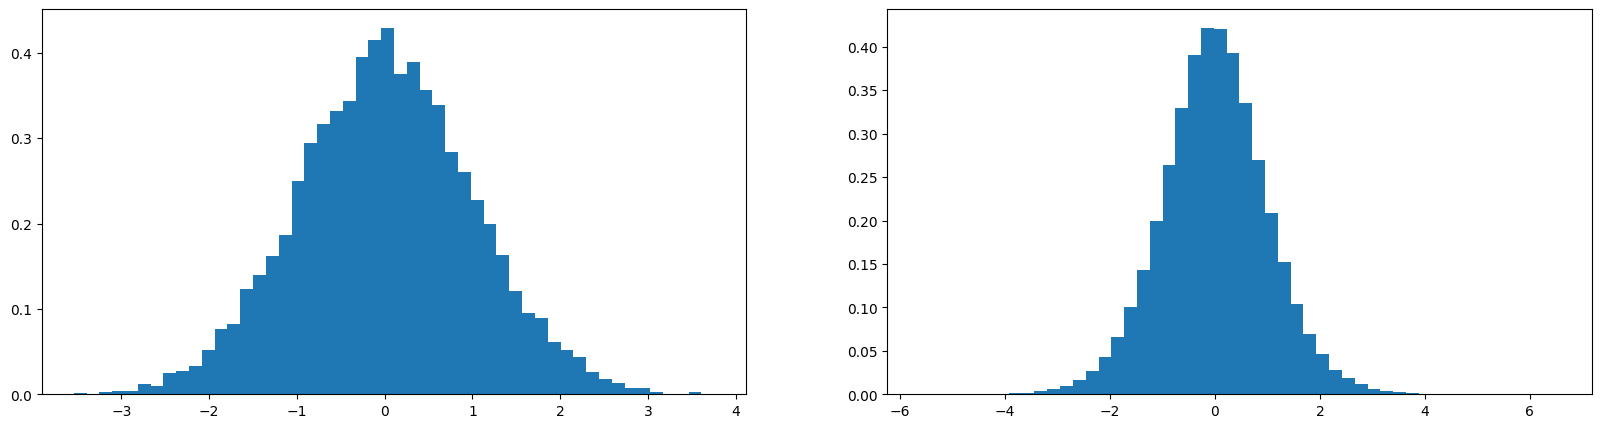

In [35]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [61]:
# Same Optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # Concatenate the vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

    # Batch Normalization
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2    # Output layer
    loss = F.cross_entropy(logits, Yb) # Loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    #break


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


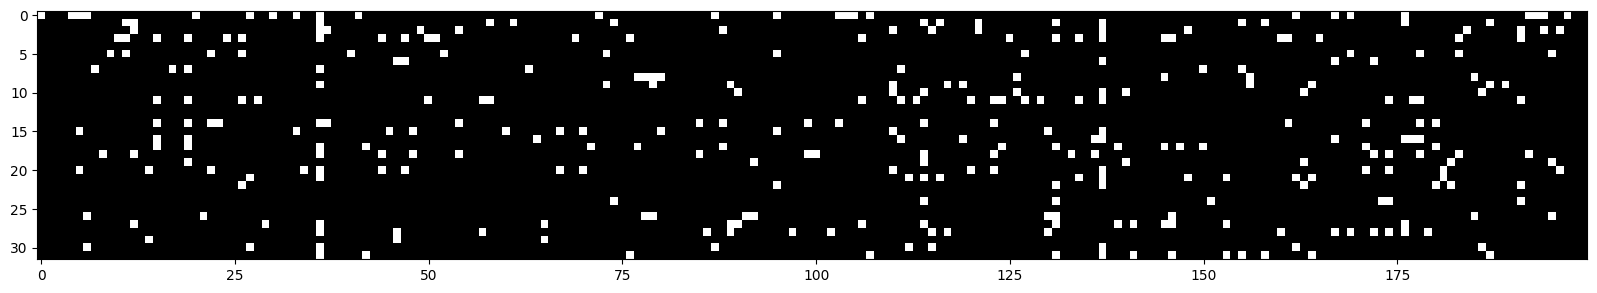

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation='nearest')

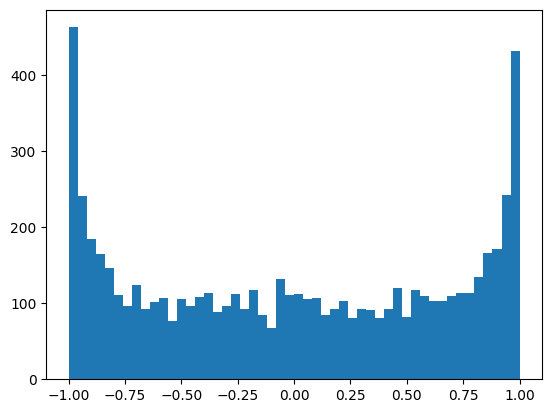

In [37]:
plt.hist(h.view(-1).tolist(), 50);

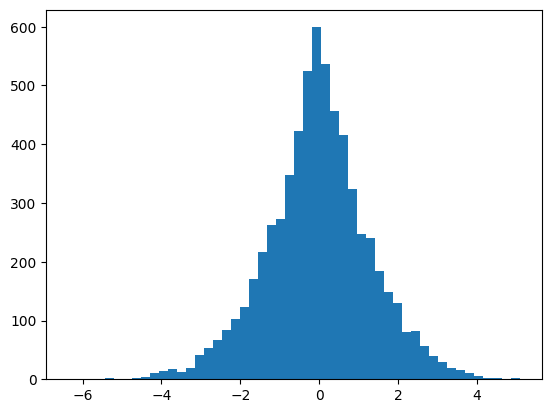

In [38]:
plt.hist(hpreact.view(-1).tolist(), 50);

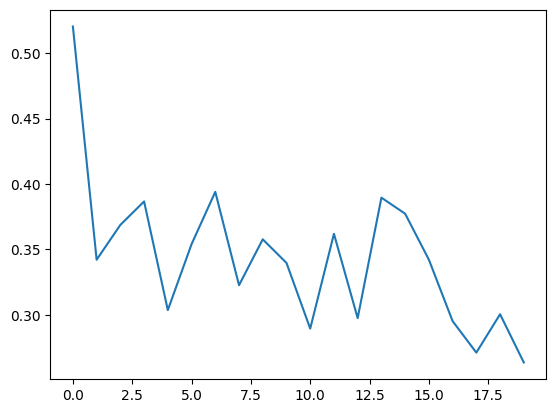

In [39]:
plt.plot(lossi)

In [62]:
# Calibrate the batch norm at the end of training

with torch.no_grad():
    # Pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    # Measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [63]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xval, Yval),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embd)
    h = torch.tanh(embcat @ W1) #+ b1) # (N, n_hidden)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 3.0724263191223145
val 3.1009275913238525


In [26]:
# Loss log

# Original:
train : 2.12
val : 2.17

# Fix softmax confidently wrong:
train : 2.07 
val : 2.13

# Fix tanh too satured at init:
train : 2.04
val : 2.10

# Use semi-principled "kaiming init" instead of hacky init:
train : 2.04
val: 2.17

# Add a batch norm layer
train: 2.07
val: 2.10

In [59]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # If we sample all the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

briahgmnazzierstel.
fhal.
qetvangendra.
zasderidgmlillshi.
jedrekesslangfarremyahmilkarib.
shdumrithghnestin.
jewtdvi.
xibuscfsubferndersymphi.
qhiyrahshvykoldnihannaviyahsufizajahkirrentirbbisvekostep.
qwilfeyroshbh.
zprixabumushwa.
hmarishid.
qinfelvshlwaldarikthrishthziroisticlitgftrvissivishmellakethrishldahmaudkeshdekitya.
blvardtaiweddie.
virlq.
saadenaysophlrystta.
ziyah.
vontet.
judnylissaphrygnovevt.
jshmptrykshmphithlisandvekessamariopsi.


# Batch Normalization

hpreact si normalizza sottraendo la media e dividendo per la varianza

Ha un effetto positivo di regularization perchè lega matematicamente gli elementi di quel batch

Quando si usa un batch normalization e prima c'è un layer conv o lineare, non ha senso aggiungere bias<br>
I bias verrebbero sottratti poi nella batch normalization quando si sottrae la media al numeratore